<a href="https://colab.research.google.com/github/IntellectualCoders/RoundHacksDTU2021/blob/main/RoundHacksDTU2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Round Hacks DTU (5-7th March)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
url='https://raw.githubusercontent.com/IntellectualCoders/RoundHacksDTU2021/main/new_train.csv'
df=pd.read_csv(url)

In [ ]:
print(df.shape)

(14884, 2)


In [ ]:
df.head(5)

,date,temp
0,1980-01-01,4.16
1,1980-01-02,4.06
2,1980-01-03,7.12
3,1980-01-04,9.23
4,1980-01-05,3.20


In [ ]:
# mask = (df['date'] >= '2001-01-01') 
# df = df.loc[mask]

# Reset the index 
df.set_index("date", inplace=True)

# Inspect first 5 rows and last 5 rows of the data
from IPython.display import display
display(df.head(5))
display(df.tail(5))

,temp
date,
1980-01-01,4.16
1980-01-02,4.06
1980-01-03,7.12
1980-01-04,9.23
1980-01-05,3.20


,temp
date,
2020-09-26,NaN
2020-09-27,NaN
2020-09-28,NaN
2020-09-29,NaN
2020-09-30,NaN


In [ ]:
print(df.shape)

(14884, 1)


In [ ]:
df.describe()

,temp
count,11323.000000
mean,15.573259
std,7.877191
min,-5.110000
25%,8.390000
50%,15.990000
75%,22.055000
max,32.390000


In [ ]:
print(df.loc[df["temp"] == df["temp"].max()])
print(df.loc[df["temp"] == df["temp"].min()])

             temp
date             
2004-07-20  32.39
            temp
date            
1984-02-07 -5.11


#Data Visualization

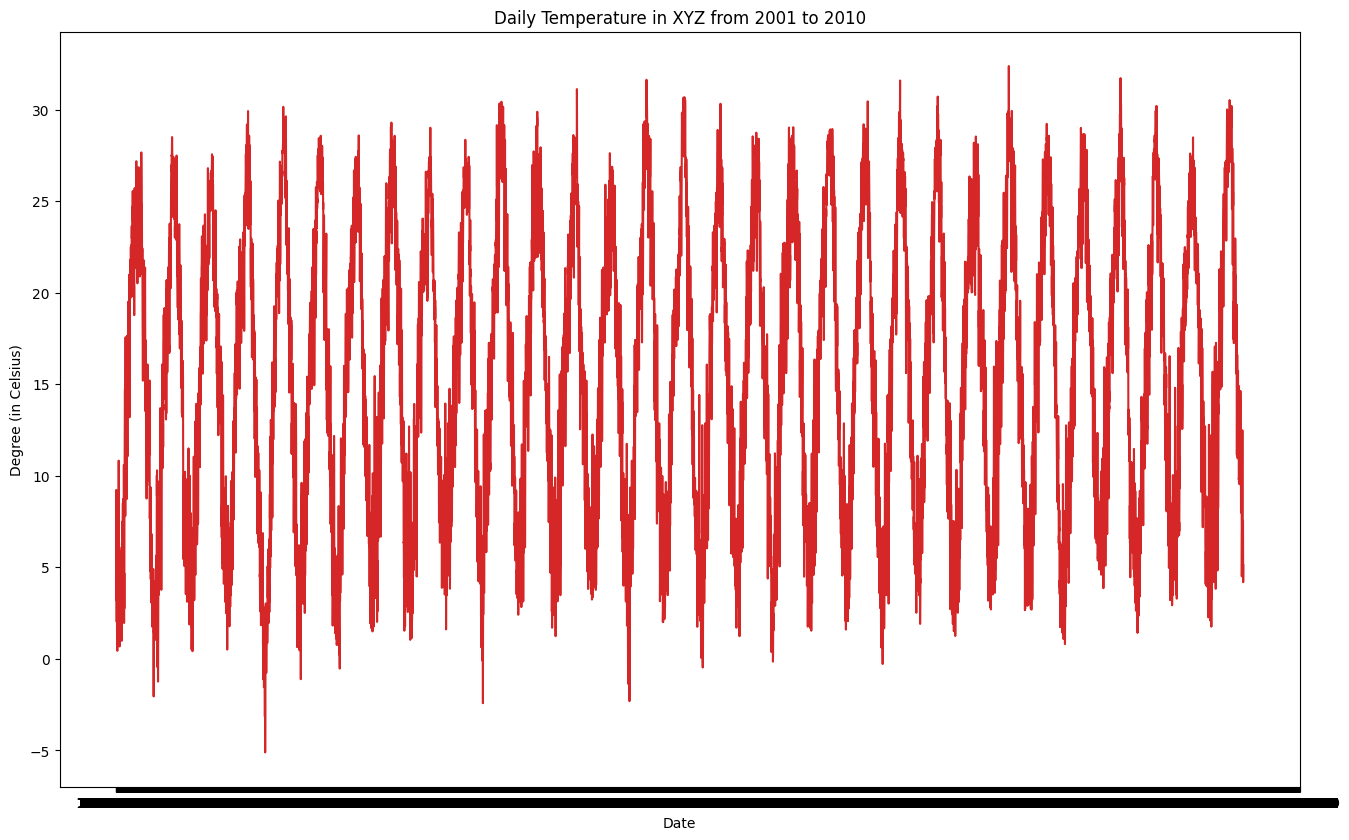

In [ ]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df.index, df.temp, color='tab:red')
plt.gca().set(title="Daily Temperature in XYZ from 2001 to 2010", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

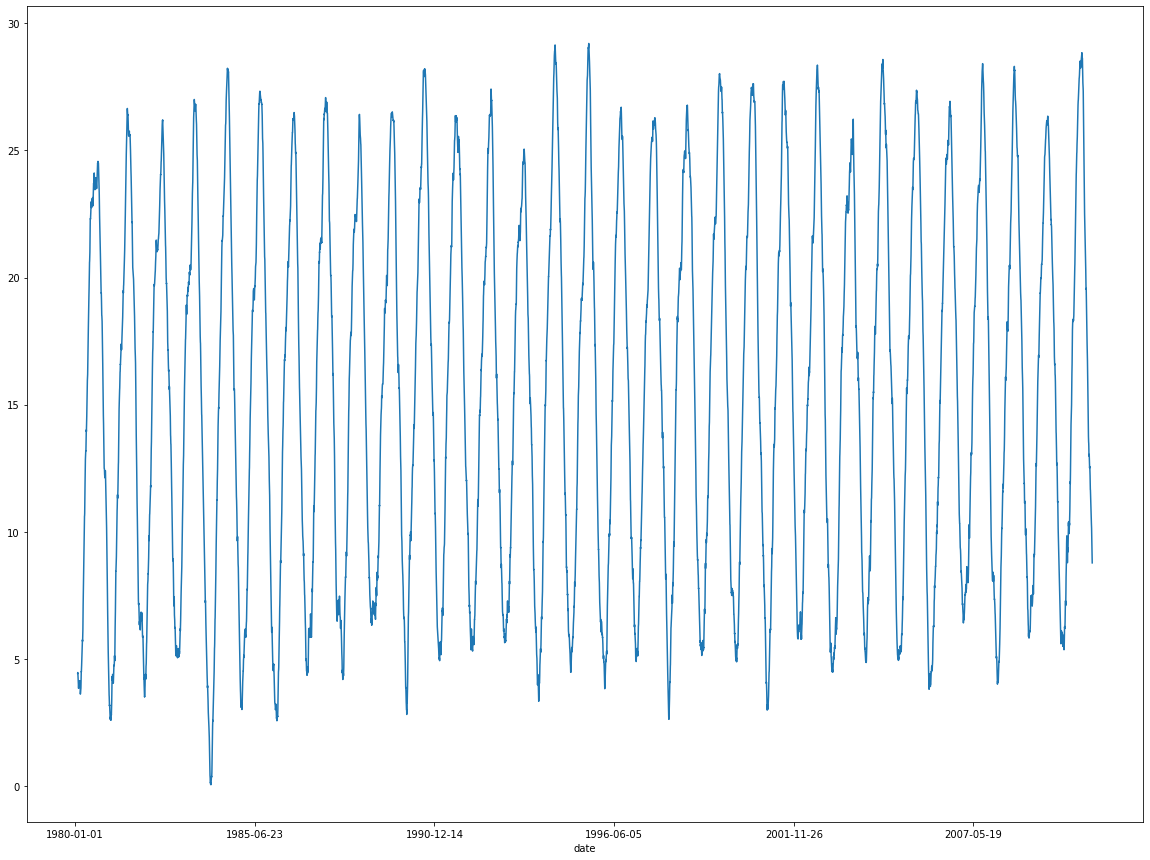

In [ ]:
temp_df_mean = df.temp.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Additive Decomposition
# result_add = seasonal_decompose(df.temp, model='additive', extrapolate_trend='freq', freq=365)

# # Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot().suptitle('Additive Decomposition', fontsize=22)
# plt.show()

ValueError: ignored

In [37]:
# Shift the current temperature to the next day. 
predicted_df = df["temp"].to_frame().shift(3561).rename(columns = {"temp": "temp_pred" })
actual_df = df["temp"].to_frame().rename(columns = {"temp": "temp_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.tail(10)

NameError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df.temp_actual, one_step_df.temp_pred, squared=False)
print("The RMSE is",temp_pred_err)

ValueError: ignored

#SARIMA Model

In [ ]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.temp_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.temp_pred,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
results

##Model Diagonistics

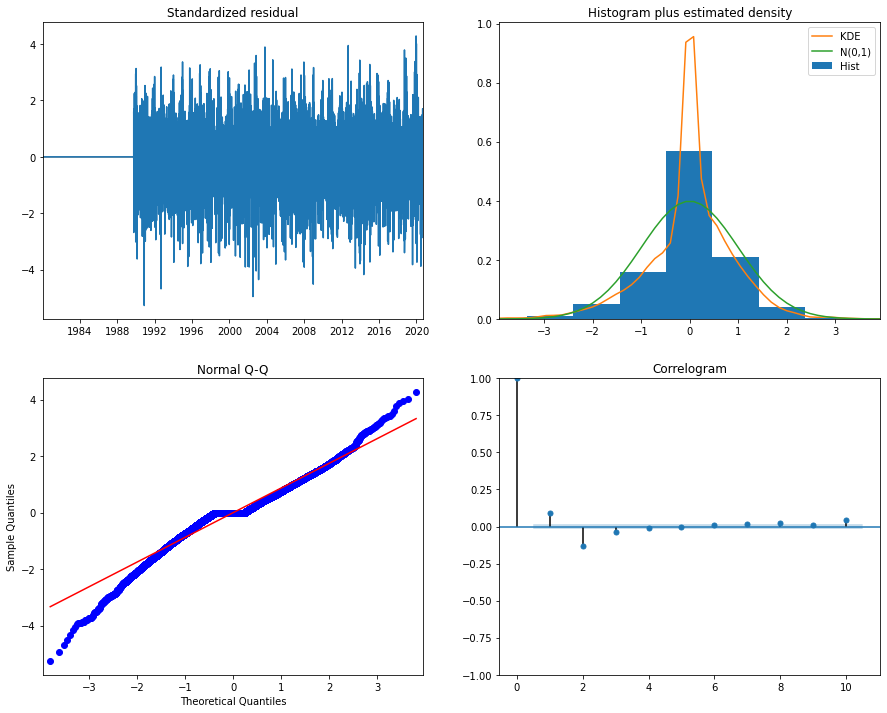

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)
pred_ci = pred.conf_int()

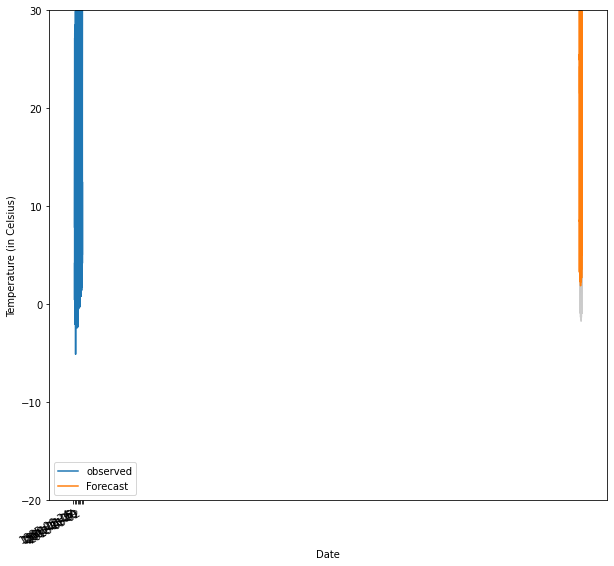

In [ ]:
ax = one_step_df.temp_pred['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
print(y_forecasted.tail(5))

2020-09-26    6.817290
2020-09-27    5.926284
2020-09-28    7.561578
2020-09-29    6.781278
2020-09-30    5.087955
Freq: D, dtype: float64


In [ ]:
rows = zip(y_forecasted1)

In [ ]:
# rows = zip(y_forecasted1)
import csv

with open('submission3.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.temp_actual['2001-04-02':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

#Dynamic Forcasted

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

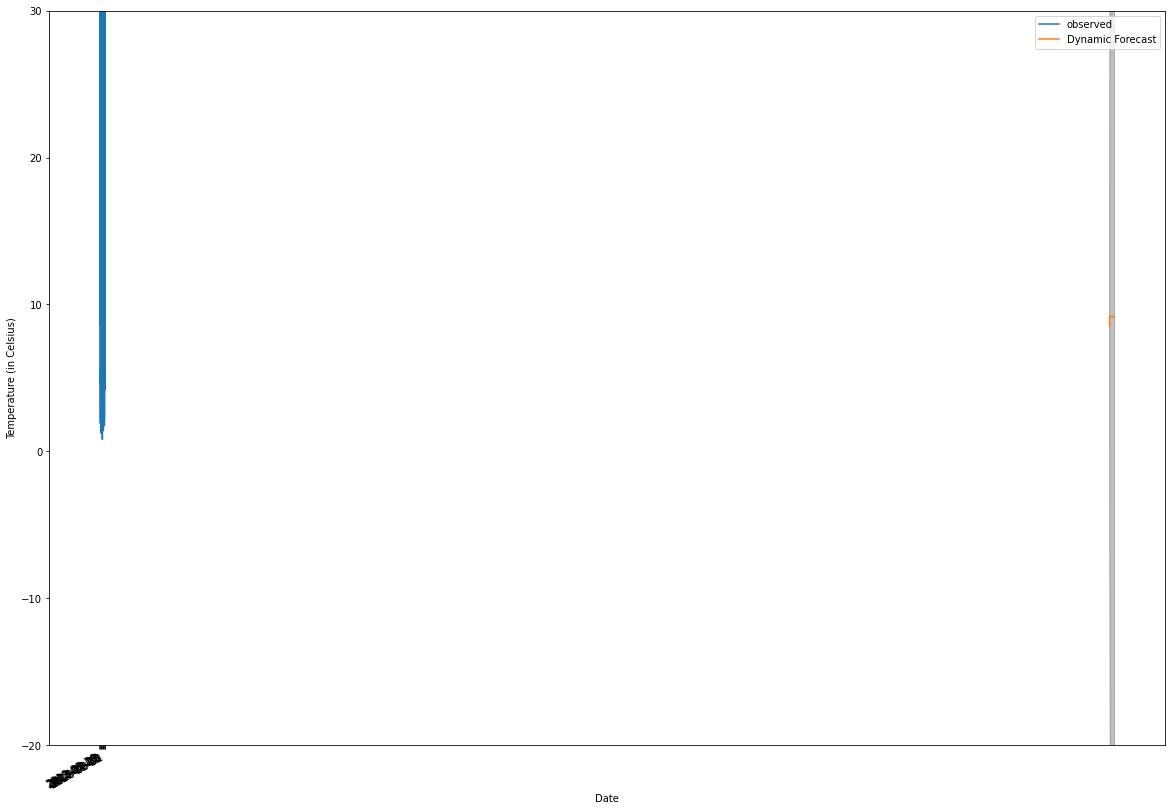

In [ ]:
ax = one_step_df.temp_pred['2011':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [ ]:
y_forecasted1 = pred_dynamic.predicted_mean
y_forecasted1.head(5)

2011-01-01    8.509582
2011-01-02    8.721755
2011-01-03    8.841699
2011-01-04    9.057507
2011-01-05    9.053396
Freq: D, dtype: float64



---



# Second Approach(LSTM)

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

In [25]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

In [26]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import array

In [28]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)

In [29]:
n_timestamp = 10
train_days = 8492  # number of days to train from
testing_days = 2831 # number of days to be predicted
n_epochs = 10
filter_on = 1

In [30]:
url = "https://raw.githubusercontent.com/IntellectualCoders/RoundHacksDTU2021/main/new_train.csv"
dataset = pd.read_csv(url)
# if filter_on == 1:
#     dataset['temp'] = medfilt(dataset['temp'], 3)
#     dataset['temp'] = gaussian_filter1d(dataset['temp'], 1.2)


In [31]:
url = "https://raw.githubusercontent.com/IntellectualCoders/RoundHacksDTU2021/main/new_test.csv"
dataset_test = pd.read_csv(url)

In [32]:
train_set = dataset.reset_index(drop=True)
test_set = dataset_test.reset_index(drop=True)
training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 0:1].values

In [35]:
training_set

array([[4.16],
       [4.06],
       [7.12],
       ...,
       [6.45],
       [4.19],
       [5.12]])

In [36]:
testing_set

array([['01-01-2011'],
       ['02-01-2011'],
       ['03-01-2011'],
       ...,
       ['28-09-2020'],
       ['29-09-2020'],
       ['30-09-2020']], dtype=object)

In [ ]:
# sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(training_set)
# testing_set_scaled = sc.fit_transform(testing_set)

In [10]:
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [11]:
testing_set

array([['01-01-2011'],
       ['02-01-2011'],
       ['03-01-2011'],
       ...,
       ['28-09-2020'],
       ['29-09-2020'],
       ['30-09-2020']], dtype=object)

In [12]:
X_train, y_train = data_split(training_set, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = testing_set.reshape(testing_set.shape[0], testing_set.shape[1], 1)

In [22]:
X_train.shape

(11313, 10, 1)

In [14]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

In [15]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/10
354/354 [==============================] - 7s 13ms/step - loss: 59.5992
Epoch 2/10
354/354 [==============================] - 4s 12ms/step - loss: 0.1382
Epoch 3/10
354/354 [==============================] - 4s 12ms/step - loss: 0.0677
Epoch 4/10
354/354 [==============================] - 4s 12ms/step - loss: 0.0624
Epoch 5/10
354/354 [==============================] - 4s 12ms/step - loss: 0.0397
Epoch 6/10
354/354 [==============================] - 5s 13ms/step - loss: 0.0386
Epoch 7/10
354/354 [==============================] - 4s 12ms/step - loss: 0.0344
Epoch 8/10
354/354 [==============================] - 4s 12ms/step - loss: 0.0366
Epoch 9/10
354/354 [==============================] - 4s 12ms/step - loss: 0.0289
Epoch 10/10
354/354 [==============================] - 4s 12ms/step - loss: 0.0376


In [121]:
X_test.shape

(3561, 1, 1)

In [ ]:
y_predicted = model.predict(X_test)

UnimplementedError: ignored

In [ ]:
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


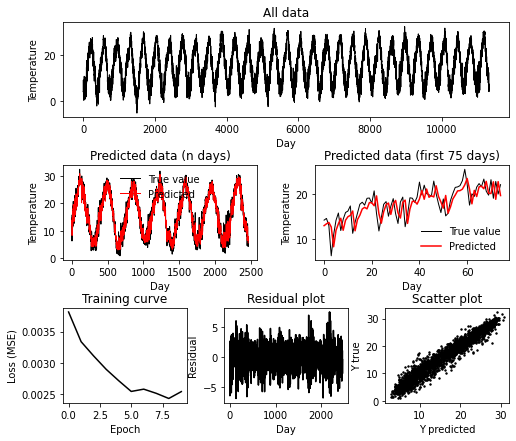

In [ ]:
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['temp'], color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("All data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (n days)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0:75], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled[0:75], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 75 days)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()




In [ ]:
mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

mse=3.24
r2=0.95




---



# Third Approach(Linear Regression)

In [53]:
url = "https://raw.githubusercontent.com/IntellectualCoders/RoundHacksDTU2021/main/new_train.csv"
df = pd.read_csv(url)

In [54]:
url = "https://raw.githubusercontent.com/IntellectualCoders/RoundHacksDTU2021/main/new_test.csv"
dataset_test = pd.read_csv(url)

In [55]:
predicted_df = df["temp"].to_frame().shift(-3561).rename(columns = {"temp": "temp_pred" })
actual_df = df["temp"].to_frame().rename(columns = {"temp": "temp_actual" })

one_step_df = pd.concat([actual_df,predicted_df],axis=1)

one_step_df = one_step_df[1:]
one_step_df.tail(10)

,temp_actual,temp_pred
11313,12.49,NaN
11314,9.34,NaN
11315,6.63,NaN
11316,5.50,NaN
11317,6.36,NaN
11318,5.42,NaN
11319,7.54,NaN
11320,6.45,NaN
11321,4.19,NaN
11322,5.12,NaN


In [108]:
cols= list(one_step_df.columns.values)
Xtrain = one_step_df[cols[0:1]][:7761]
ytrain = one_step_df[cols[1:2]][:7761]
Xtest = one_step_df[cols[0:1]][7761:]

In [109]:
Xtest.tail()

,temp_actual
11318,5.42
11319,7.54
11320,6.45
11321,4.19
11322,5.12


In [106]:
Xtrain.head()

,temp_actual
1,4.06
2,7.12
3,9.23
4,3.20
5,7.01


In [107]:
ytrain.head()

,temp_pred
1,18.45
2,18.40
3,17.79
4,20.10
5,20.35


In [56]:
train_set = one_step_df.reset_index(drop=True)
# test_set = df_test.reset_index(drop=True)
training_set = train_set.iloc[:, 0:2].values
# testing_set = test_set.iloc[:, 0:1].values

In [89]:
training_set[7761:]

array([[13.59,   nan],
       [12.3 ,   nan],
       [ 9.62,   nan],
       ...,
       [ 6.45,   nan],
       [ 4.19,   nan],
       [ 5.12,   nan]])

In [91]:
x_test=train_set.temp_actual[7761:]
x_test.reset_index(drop=True)

0       13.59
1       12.30
2        9.62
3       13.09
4       14.45
        ...  
3556     5.42
3557     7.54
3558     6.45
3559     4.19
3560     5.12
Name: temp_actual, Length: 3561, dtype: float64

In [92]:
y_train=train_set.temp_pred[:7761]
y_train.reset_index(drop=True)

0       18.45
1       18.40
2       17.79
3       20.10
4       20.35
        ...  
7756     5.42
7757     7.54
7758     6.45
7759     4.19
7760     5.12
Name: temp_pred, Length: 7761, dtype: float64

In [93]:
x_train = train_set.temp_actual[:7761]
x_train.reset_index(drop=True)

0        4.06
1        7.12
2        9.23
3        3.20
4        7.01
        ...  
7756    11.75
7757     6.68
7758     7.49
7759     3.02
7760     8.12
Name: temp_actual, Length: 7761, dtype: float64

In [110]:
from sklearn.linear_model import LinearRegression

In [111]:
model = LinearRegression()

In [112]:
model.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [113]:
y_pred = model.predict(Xtest)

In [119]:
rows = zip(y_pred)

In [116]:
import csv

with open('submission4.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)